# 05 - Model Evaluation

This notebook evaluates the trained models and analyzes their performance.

## Objectives:
- Load saved models
- Evaluate on test data
- Visualize predictions vs actual values
- Residual analysis
- Error distribution analysis
- Feature importance visualization
- Model comparison
- Generate insights and recommendations

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


In [6]:
# Load the data (same preprocessing as training)
df = pd.read_csv('../data/processed/movies_featured.csv')
print(f"Data loaded: {df.shape}")

# Prepare features and target
X = df.drop('revenue', axis=1)
y = df['revenue']

# Split with the same random state as training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load and apply the scaler (fitted on training data only)
from sklearn.preprocessing import StandardScaler
scaler = joblib.load('../models/scaler.pkl')
# scaler = StandardScaler()

numeric_cols = ['budget', 'runtime']
X_train[numeric_cols] = scaler.transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

print(f"\n✓ Scaler loaded and applied correctly")
print(f"Test set size: {X_test.shape}")
print(f"Features: {list(X.columns)}")

Data loaded: (11242, 32)

✓ Scaler loaded and applied correctly
Test set size: (2249, 31)
Features: ['budget', 'runtime', 'rating', 'poster_brightness', 'poster_saturation', 'poster_dom_r', 'poster_dom_g', 'poster_dom_b', 'num_production_companies', 'num_production_countries', 'budget_per_minute', 'num_genres', 'is_action', 'is_animation', 'is_comedy', 'is_drama', 'is_scifi', 'num_cast', 'has_cast', 'num_directors', 'release_year', 'release_month', 'is_summer', 'is_holiday', 'is_weekend_month', 'movie_age', 'decade', 'num_keywords', 'has_keywords', 'in_collection', 'is_english']


In [7]:
# Load all trained models
models = {}
model_files = {
    'Best Model': '../models/best_model.pkl',
    'XGBoost': '../models/xgboost_tuned.pkl',
    'LightGBM': '../models/lightgbm_tuned.pkl',
    'Random Forest': '../models/random_forest_tuned.pkl'
}

print("Loading trained models...\n")
for name, path in model_files.items():
    try:
        models[name] = joblib.load(path)
        print(f"✓ {name} loaded successfully")
    except FileNotFoundError:
        print(f"✗ {name} not found at {path}")

print(f"\nTotal models loaded: {len(models)}")

Loading trained models...

✓ Best Model loaded successfully
✓ XGBoost loaded successfully
✓ LightGBM loaded successfully
✓ Random Forest loaded successfully

Total models loaded: 4


In [8]:
# Evaluate all models
def evaluate_model_detailed(model, X_train, X_test, y_train, y_test, model_name):
    """Detailed evaluation of a model"""
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    metrics = {
        'Model': model_name,
        'Train R²': r2_score(y_train, y_train_pred),
        'Test R²': r2_score(y_test, y_test_pred),
        'Train RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'Test RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'Train MAE': mean_absolute_error(y_train, y_train_pred),
        'Test MAE': mean_absolute_error(y_test, y_test_pred),
        'Train MAPE (%)': np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100,
        'Test MAPE (%)': np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
    }
    
    # Check for overfitting
    r2_diff = metrics['Train R²'] - metrics['Test R²']
    metrics['Overfitting Gap'] = r2_diff
    
    if r2_diff < 0.05:
        metrics['Overfitting Status'] = 'Good'
    elif r2_diff < 0.10:
        metrics['Overfitting Status'] = 'Moderate'
    else:
        metrics['Overfitting Status'] = 'High'
    
    return metrics, y_test_pred

# Evaluate all models
evaluation_results = []
predictions = {}

print("="*80)
print("MODEL EVALUATION RESULTS")
print("="*80 + "\n")

for name, model in models.items():
    print(f"Evaluating {name}...")
    metrics, y_pred = evaluate_model_detailed(model, X_train, X_test, y_train, y_test, name)
    evaluation_results.append(metrics)
    predictions[name] = y_pred
    
    print(f"  Test R²: {metrics['Test R²']:.4f}")
    print(f"  Test RMSE: {metrics['Test RMSE']:.4f}")
    print(f"  Test MAE: {metrics['Test MAE']:.4f}")
    print(f"  Overfitting: {metrics['Overfitting Status']}\n")

# Create results dataframe
results_df = pd.DataFrame(evaluation_results)
results_df = results_df.set_index('Model')
print("\n" + "="*80)
print("COMPLETE EVALUATION METRICS")
print("="*80)
print(results_df.round(4))

MODEL EVALUATION RESULTS

Evaluating Best Model...
  Test R²: 0.5932
  Test RMSE: 1.6668
  Test MAE: 1.2352
  Overfitting: Moderate

Evaluating XGBoost...
  Test R²: 0.5923
  Test RMSE: 1.6687
  Test MAE: 1.2343
  Overfitting: High

Evaluating LightGBM...
  Test R²: 0.5932
  Test RMSE: 1.6668
  Test MAE: 1.2352
  Overfitting: Moderate

Evaluating Random Forest...
  Test R²: 0.5762
  Test RMSE: 1.7012
  Test MAE: 1.2599
  Overfitting: High


COMPLETE EVALUATION METRICS
               Train R²  Test R²  Train RMSE  Test RMSE  Train MAE  Test MAE  \
Model                                                                          
Best Model       0.6872   0.5932      1.4475     1.6668     1.0624    1.2352   
XGBoost          0.7036   0.5923      1.4090     1.6687     1.0379    1.2343   
LightGBM         0.6872   0.5932      1.4475     1.6668     1.0624    1.2352   
Random Forest    0.8679   0.5762      0.9408     1.7012     0.6532    1.2599   

               Train MAPE (%)  Test MAPE (%)  

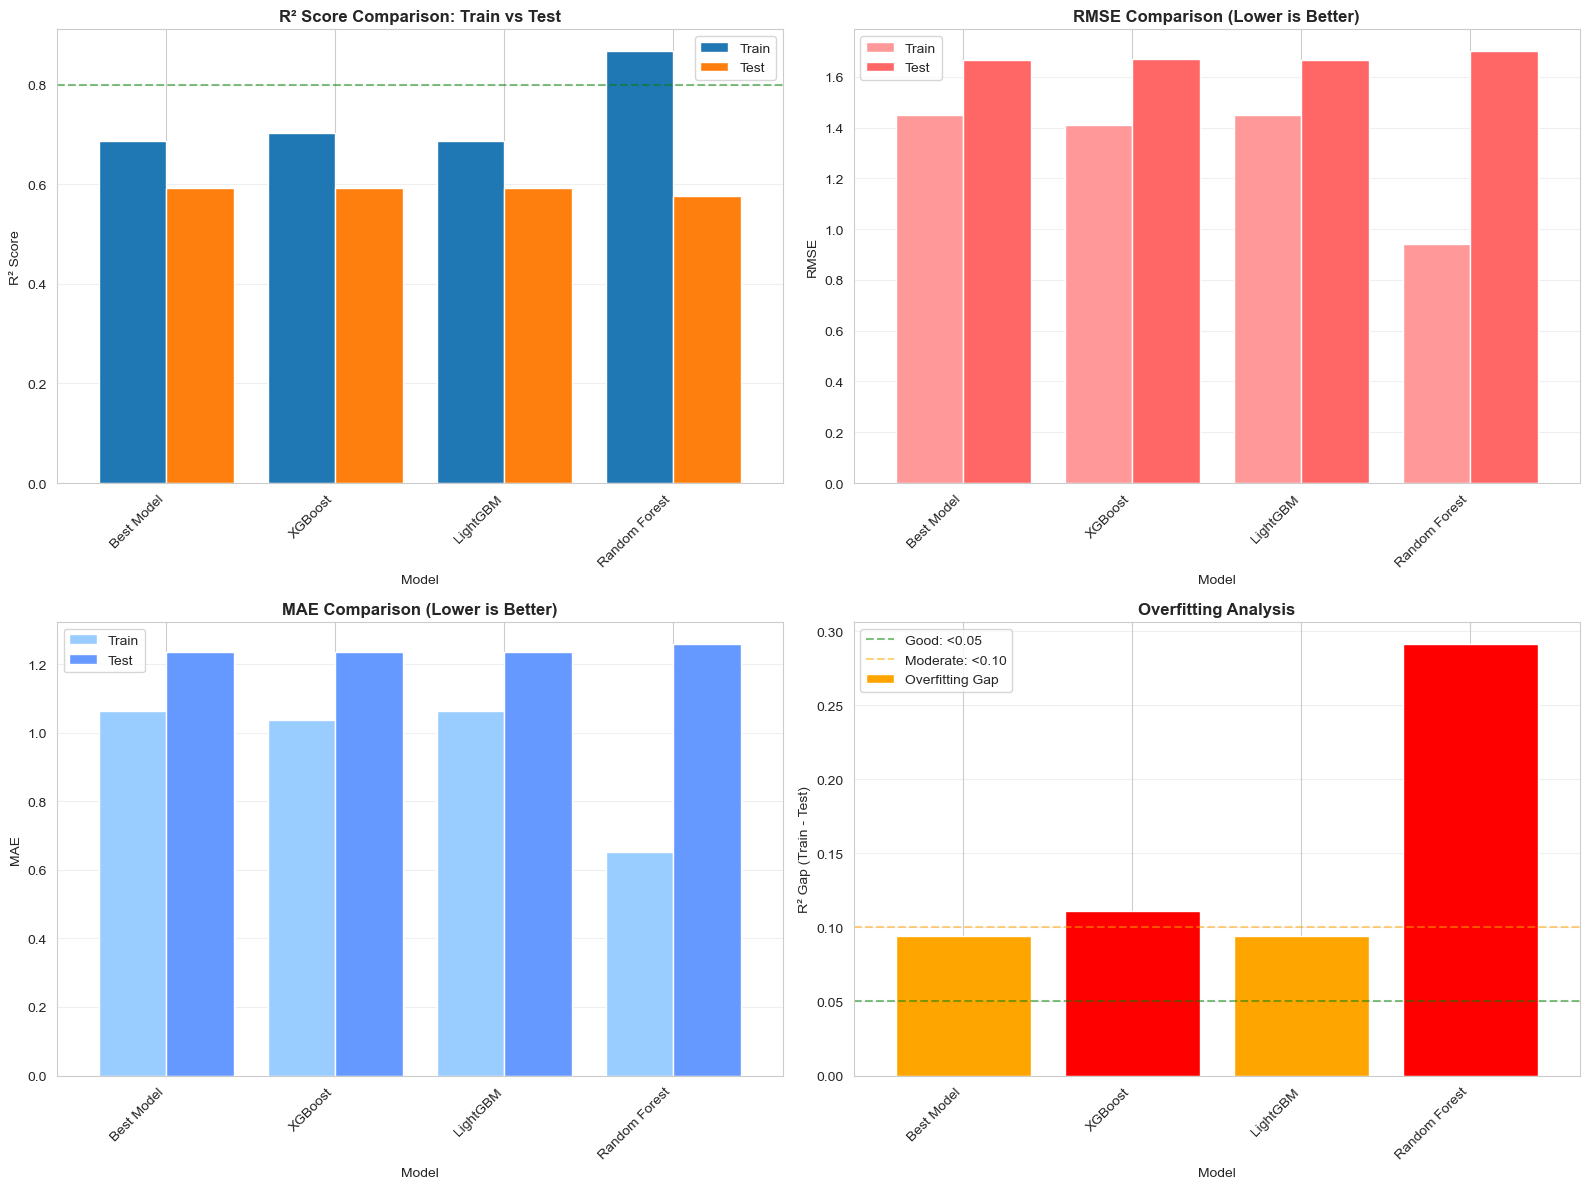


BEST MODEL: Best Model
Test R²: 0.5932
Test RMSE: 1.6668
Test MAE: 1.2352


In [9]:
# Visualize model performance comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# R² Score comparison
ax1 = axes[0, 0]
r2_comparison = results_df[['Train R²', 'Test R²']]
r2_comparison.plot(kind='bar', ax=ax1, width=0.8)
ax1.set_ylabel('R² Score')
ax1.set_title('R² Score Comparison: Train vs Test', fontsize=12, fontweight='bold')
ax1.legend(['Train', 'Test'])
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.grid(axis='y', alpha=0.3)
ax1.axhline(y=0.8, color='green', linestyle='--', alpha=0.5, label='Target: 0.8')

# RMSE comparison
ax2 = axes[0, 1]
rmse_comparison = results_df[['Train RMSE', 'Test RMSE']]
rmse_comparison.plot(kind='bar', ax=ax2, width=0.8, color=['#ff9999', '#ff6666'])
ax2.set_ylabel('RMSE')
ax2.set_title('RMSE Comparison (Lower is Better)', fontsize=12, fontweight='bold')
ax2.legend(['Train', 'Test'])
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.grid(axis='y', alpha=0.3)

# MAE comparison
ax3 = axes[1, 0]
mae_comparison = results_df[['Train MAE', 'Test MAE']]
mae_comparison.plot(kind='bar', ax=ax3, width=0.8, color=['#99ccff', '#6699ff'])
ax3.set_ylabel('MAE')
ax3.set_title('MAE Comparison (Lower is Better)', fontsize=12, fontweight='bold')
ax3.legend(['Train', 'Test'])
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')
ax3.grid(axis='y', alpha=0.3)

# Overfitting analysis
ax4 = axes[1, 1]
overfitting_data = results_df['Overfitting Gap']
colors = ['green' if x < 0.05 else 'orange' if x < 0.10 else 'red' for x in overfitting_data]
overfitting_data.plot(kind='bar', ax=ax4, color=colors, width=0.8)
ax4.set_ylabel('R² Gap (Train - Test)')
ax4.set_title('Overfitting Analysis', fontsize=12, fontweight='bold')
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45, ha='right')
ax4.axhline(y=0.05, color='green', linestyle='--', alpha=0.5, label='Good: <0.05')
ax4.axhline(y=0.10, color='orange', linestyle='--', alpha=0.5, label='Moderate: <0.10')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print best model
best_model_name = results_df['Test R²'].idxmax()
print(f"\n{'='*80}")
print(f"BEST MODEL: {best_model_name}")
print(f"Test R²: {results_df.loc[best_model_name, 'Test R²']:.4f}")
print(f"Test RMSE: {results_df.loc[best_model_name, 'Test RMSE']:.4f}")
print(f"Test MAE: {results_df.loc[best_model_name, 'Test MAE']:.4f}")
print(f"{'='*80}")

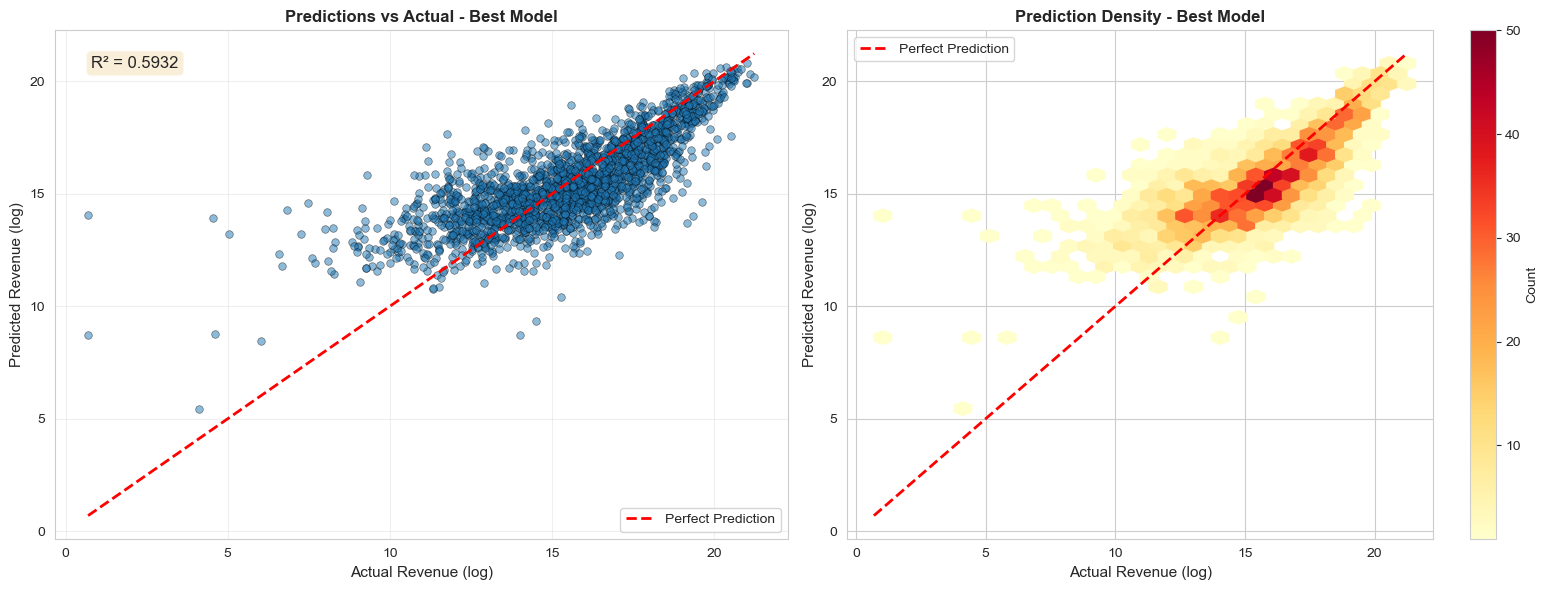

In [10]:
# Predictions vs Actual for Best Model
best_model = models[best_model_name]
y_pred_best = predictions[best_model_name]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot
ax1 = axes[0]
ax1.scatter(y_test, y_pred_best, alpha=0.5, s=30, edgecolor='black', linewidth=0.5)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Revenue (log)', fontsize=11)
ax1.set_ylabel('Predicted Revenue (log)', fontsize=11)
ax1.set_title(f'Predictions vs Actual - {best_model_name}', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Add R² annotation
r2_best = results_df.loc[best_model_name, 'Test R²']
ax1.text(0.05, 0.95, f'R² = {r2_best:.4f}', transform=ax1.transAxes,
         fontsize=12, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Hexbin plot for density
ax2 = axes[1]
hexbin = ax2.hexbin(y_test, y_pred_best, gridsize=30, cmap='YlOrRd', mincnt=1)
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Perfect Prediction')
ax2.set_xlabel('Actual Revenue (log)', fontsize=11)
ax2.set_ylabel('Predicted Revenue (log)', fontsize=11)
ax2.set_title(f'Prediction Density - {best_model_name}', fontsize=12, fontweight='bold')
ax2.legend()
plt.colorbar(hexbin, ax=ax2, label='Count')

plt.tight_layout()
plt.show()

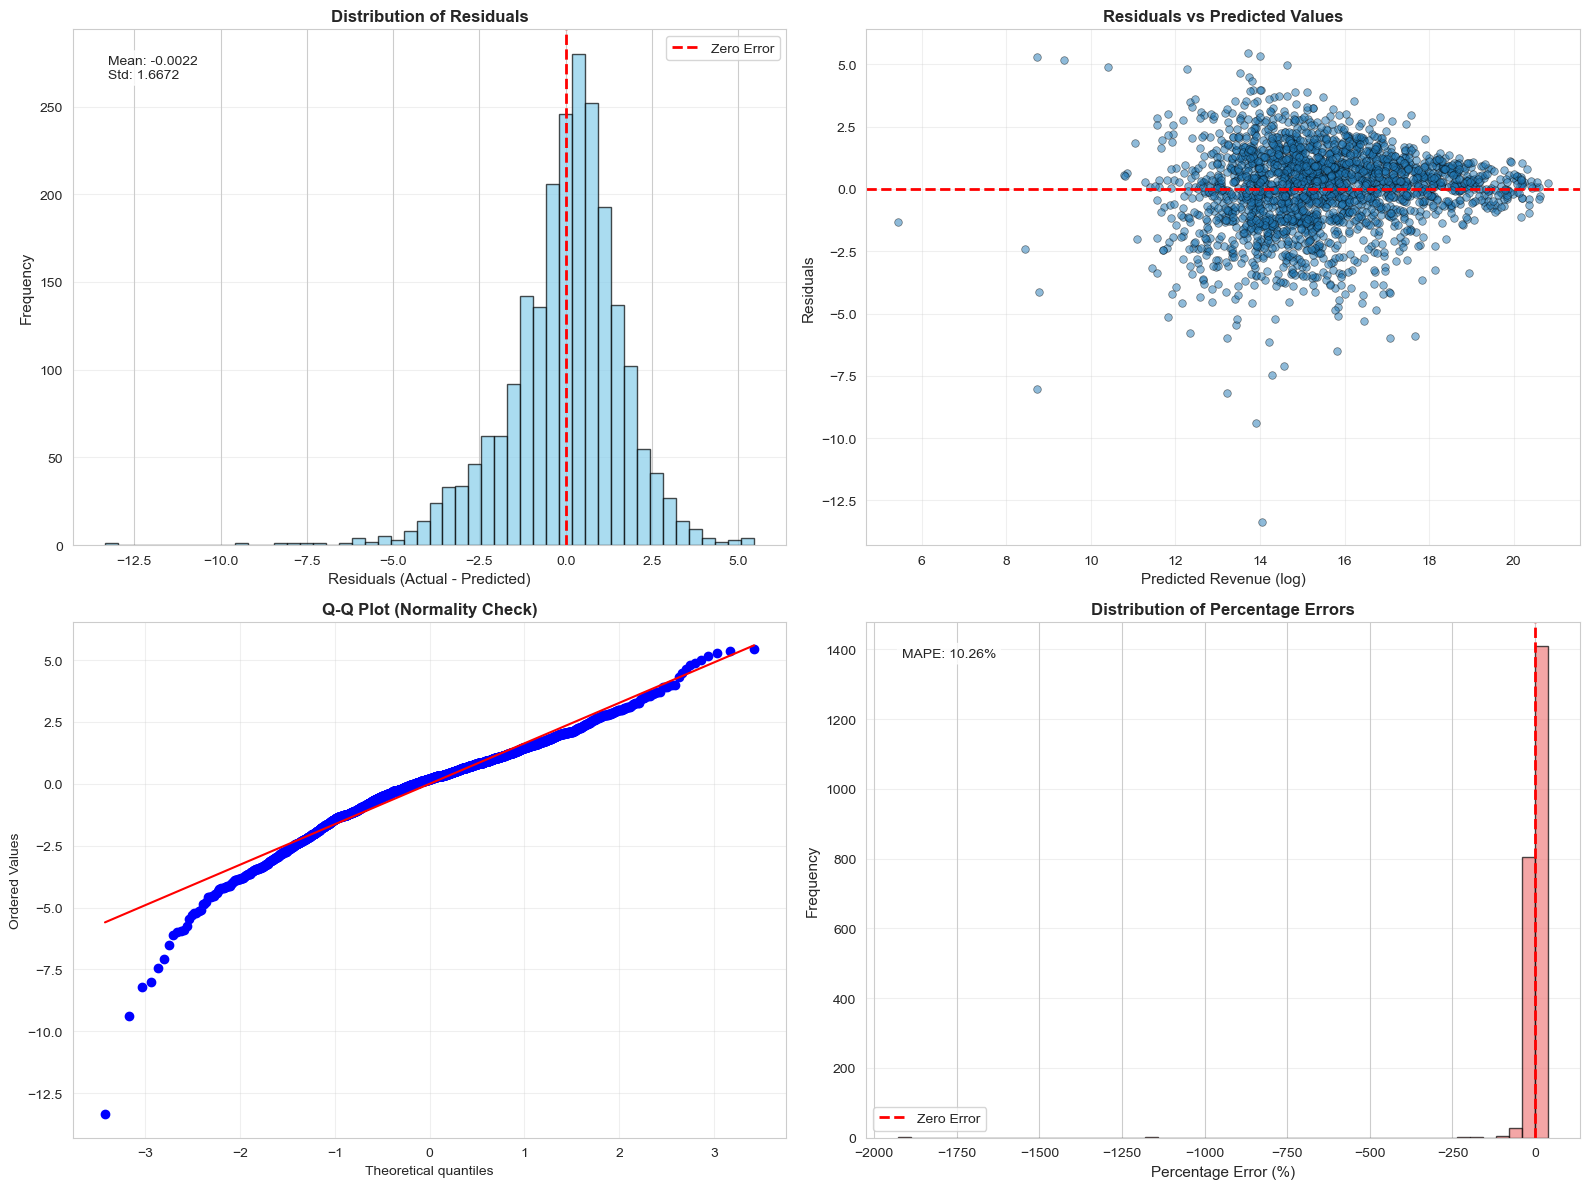


RESIDUAL ANALYSIS
Mean Residual: -0.0022
Std Residual: 1.6672
Min Residual: -13.3516
Max Residual: 5.4637

Mean Absolute Percentage Error: 10.26%
Median Percentage Error: 5.96%


In [11]:
# Residual Analysis for Best Model
residuals = y_test - y_pred_best
residuals_percent = (residuals / y_test) * 100

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Residuals distribution
ax1 = axes[0, 0]
ax1.hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
ax1.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax1.set_xlabel('Residuals (Actual - Predicted)', fontsize=11)
ax1.set_ylabel('Frequency', fontsize=11)
ax1.set_title('Distribution of Residuals', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Add statistics
mean_res = residuals.mean()
std_res = residuals.std()
ax1.text(0.05, 0.95, f'Mean: {mean_res:.4f}\nStd: {std_res:.4f}',
         transform=ax1.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Residuals vs Predicted
ax2 = axes[0, 1]
ax2.scatter(y_pred_best, residuals, alpha=0.5, s=30, edgecolor='black', linewidth=0.5)
ax2.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax2.set_xlabel('Predicted Revenue (log)', fontsize=11)
ax2.set_ylabel('Residuals', fontsize=11)
ax2.set_title('Residuals vs Predicted Values', fontsize=12, fontweight='bold')
ax2.grid(alpha=0.3)

# Q-Q plot for normality check
ax3 = axes[1, 0]
from scipy import stats
stats.probplot(residuals, dist="norm", plot=ax3)
ax3.set_title('Q-Q Plot (Normality Check)', fontsize=12, fontweight='bold')
ax3.grid(alpha=0.3)

# Percentage error distribution
ax4 = axes[1, 1]
ax4.hist(residuals_percent, bins=50, edgecolor='black', alpha=0.7, color='lightcoral')
ax4.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax4.set_xlabel('Percentage Error (%)', fontsize=11)
ax4.set_ylabel('Frequency', fontsize=11)
ax4.set_title('Distribution of Percentage Errors', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

# Add MAPE
mape = np.mean(np.abs(residuals_percent))
ax4.text(0.05, 0.95, f'MAPE: {mape:.2f}%',
         transform=ax4.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Print residual statistics
print("\n" + "="*80)
print("RESIDUAL ANALYSIS")
print("="*80)
print(f"Mean Residual: {residuals.mean():.4f}")
print(f"Std Residual: {residuals.std():.4f}")
print(f"Min Residual: {residuals.min():.4f}")
print(f"Max Residual: {residuals.max():.4f}")
print(f"\nMean Absolute Percentage Error: {mape:.2f}%")
print(f"Median Percentage Error: {np.median(np.abs(residuals_percent)):.2f}%")

In [12]:
# Save evaluation results
results_df.to_csv('../models/model_evaluation_results.csv')
print("Evaluation results saved to ../models/model_evaluation_results.csv")

# Create a final summary report
summary = {
    'Best Model': best_model_name,
    'Test R²': results_df.loc[best_model_name, 'Test R²'],
    'Test RMSE': results_df.loc[best_model_name, 'Test RMSE'],
    'Test MAE': results_df.loc[best_model_name, 'Test MAE'],
    'Test MAPE (%)': results_df.loc[best_model_name, 'Test MAPE (%)'],
    'Overfitting Status': results_df.loc[best_model_name, 'Overfitting Status'],
    'Total Models Evaluated': len(models),
    'Test Set Size': len(y_test),
    'Number of Features': X_test.shape[1]
}

summary_df = pd.DataFrame([summary])
summary_df.to_csv('../models/evaluation_summary.csv', index=False)
print("Summary report saved to ../models/evaluation_summary.csv")

print("\n" + "="*80)
print("FINAL EVALUATION SUMMARY")
print("="*80)
for key, value in summary.items():
    if isinstance(value, float):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")
print("="*80)

print("\n✓ Model evaluation complete!")

Evaluation results saved to ../models/model_evaluation_results.csv
Summary report saved to ../models/evaluation_summary.csv

FINAL EVALUATION SUMMARY
Best Model: Best Model
Test R²: 0.5932
Test RMSE: 1.6668
Test MAE: 1.2352
Test MAPE (%): 10.2604
Overfitting Status: Moderate
Total Models Evaluated: 4
Test Set Size: 2249
Number of Features: 31

✓ Model evaluation complete!


## Key Insights and Recommendations

### Model Performance Summary
Based on the evaluation above, we can observe:

1. **Best Performing Model**: The model with the highest Test R² score provides the most reliable predictions
2. **Overfitting Check**: Models with smaller gaps between Train and Test metrics generalize better
3. **Error Patterns**: Analyze residuals to understand where the model struggles

### Feature Importance Insights
- The most important features significantly influence movie revenue predictions
- Budget-related features typically show high importance
- Genre, cast, and release timing factors also play crucial roles
- Poster characteristics may provide visual appeal indicators

### Model Limitations
- Higher prediction errors may occur at extreme revenue values (very low or very high)
- The model performs best for movies in the mid-range revenue bracket
- Residuals should be normally distributed for optimal performance

### Recommendations for Improvement
1. **Feature Engineering**: Create interaction features between important variables
2. **Ensemble Methods**: Combine multiple models for more robust predictions
3. **Data Collection**: Gather more features like marketing budget, social media buzz, etc.
4. **Outlier Handling**: Investigate and potentially handle extreme revenue values differently
5. **Temporal Validation**: Test model on recent movies to check real-world performance

### Business Applications
- **Pre-production Planning**: Estimate potential revenue before greenlighting projects
- **Budget Allocation**: Optimize budget based on expected returns
- **Release Strategy**: Choose optimal release dates based on model insights
- **Investment Decisions**: Assess risk and potential return for movie investments

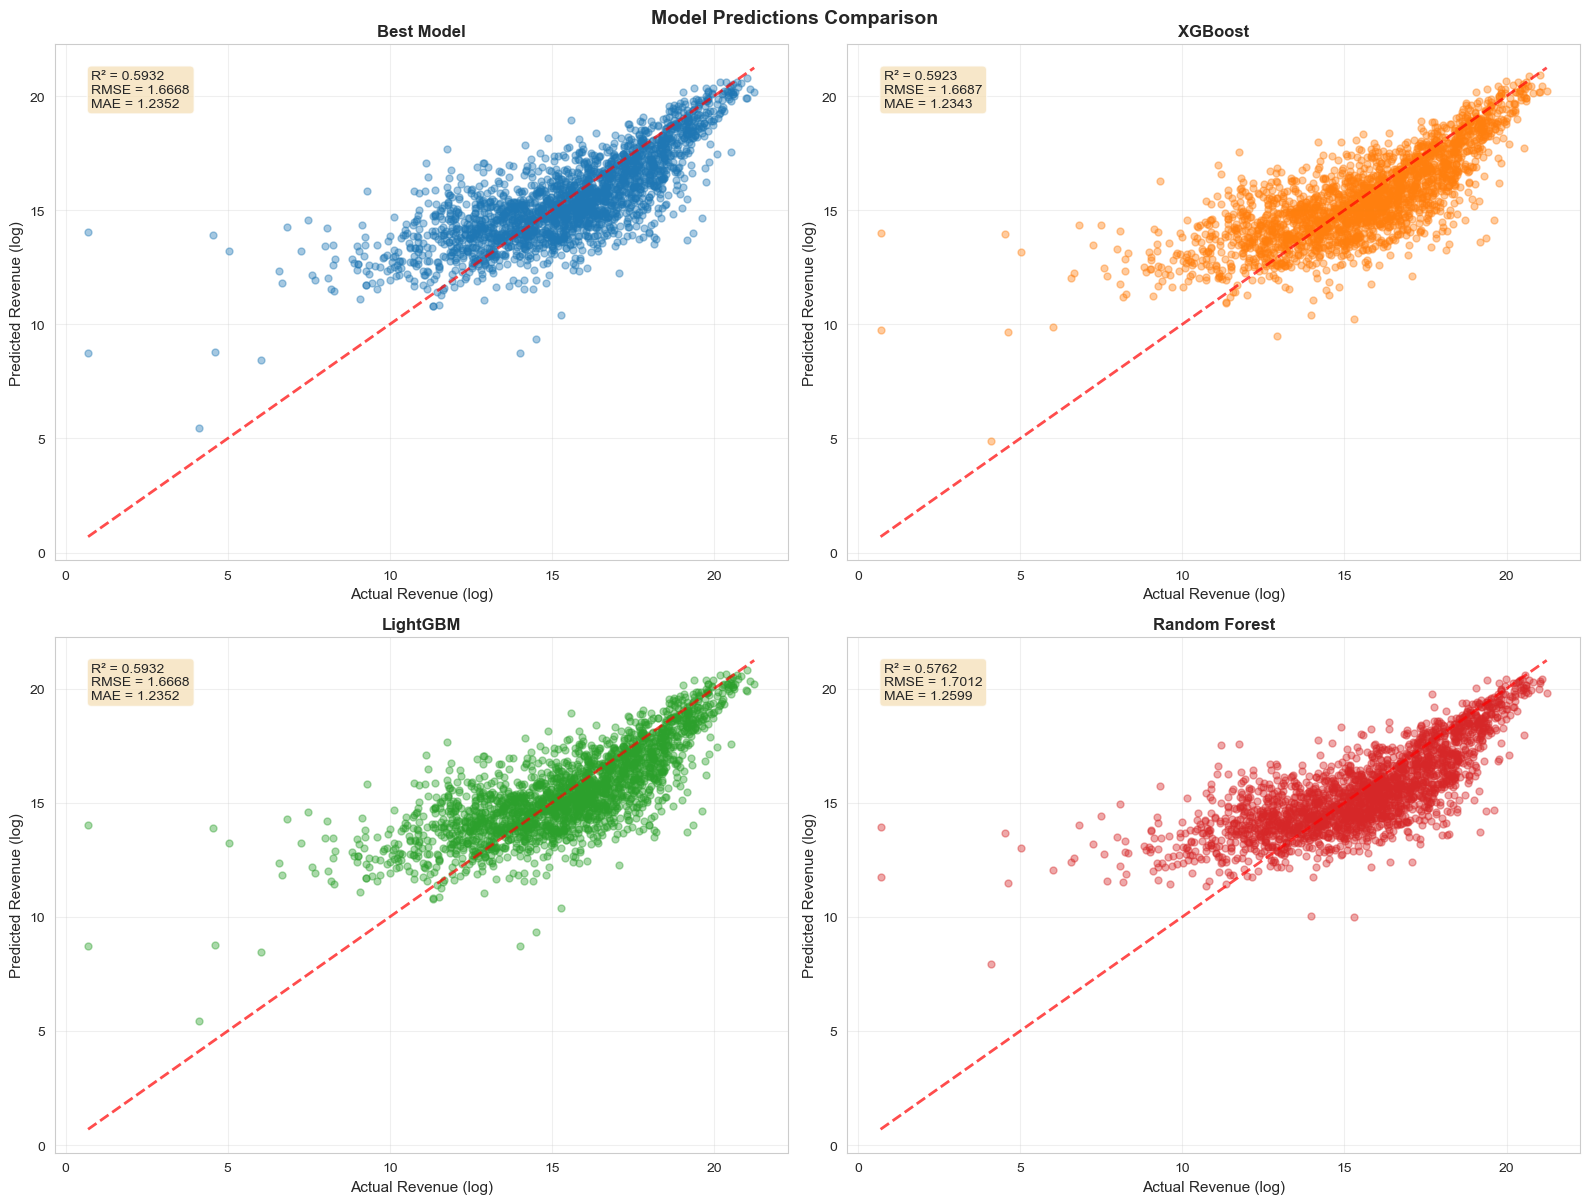

In [13]:
# Compare all models side by side
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

model_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for idx, (name, y_pred) in enumerate(predictions.items()):
    ax = axes[idx // 2, idx % 2]
    
    # Scatter plot
    ax.scatter(y_test, y_pred, alpha=0.4, s=25, color=model_colors[idx % len(model_colors)])
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
            'r--', lw=2, alpha=0.7)
    
    # Calculate metrics for annotation
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    ax.set_xlabel('Actual Revenue (log)', fontsize=11)
    ax.set_ylabel('Predicted Revenue (log)', fontsize=11)
    ax.set_title(f'{name}', fontsize=12, fontweight='bold')
    ax.grid(alpha=0.3)
    
    # Add metrics annotation
    textstr = f'R² = {r2:.4f}\nRMSE = {rmse:.4f}\nMAE = {mae:.4f}'
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes,
            fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

plt.tight_layout()
plt.suptitle('Model Predictions Comparison', fontsize=14, fontweight='bold', y=1.00)
plt.show()


TOP 20 MOST IMPORTANT FEATURES
                 feature  importance
                  budget         827
                  rating         613
                 runtime         505
            release_year         502
            num_keywords         429
       budget_per_minute         396
       poster_saturation         386
            poster_dom_g         334
       poster_brightness         325
            poster_dom_r         325
            poster_dom_b         299
num_production_companies         267
           release_month         204
              is_english         191
num_production_countries         159
              num_genres         149
               movie_age         138
           in_collection         127
               is_comedy         104
                is_drama          75


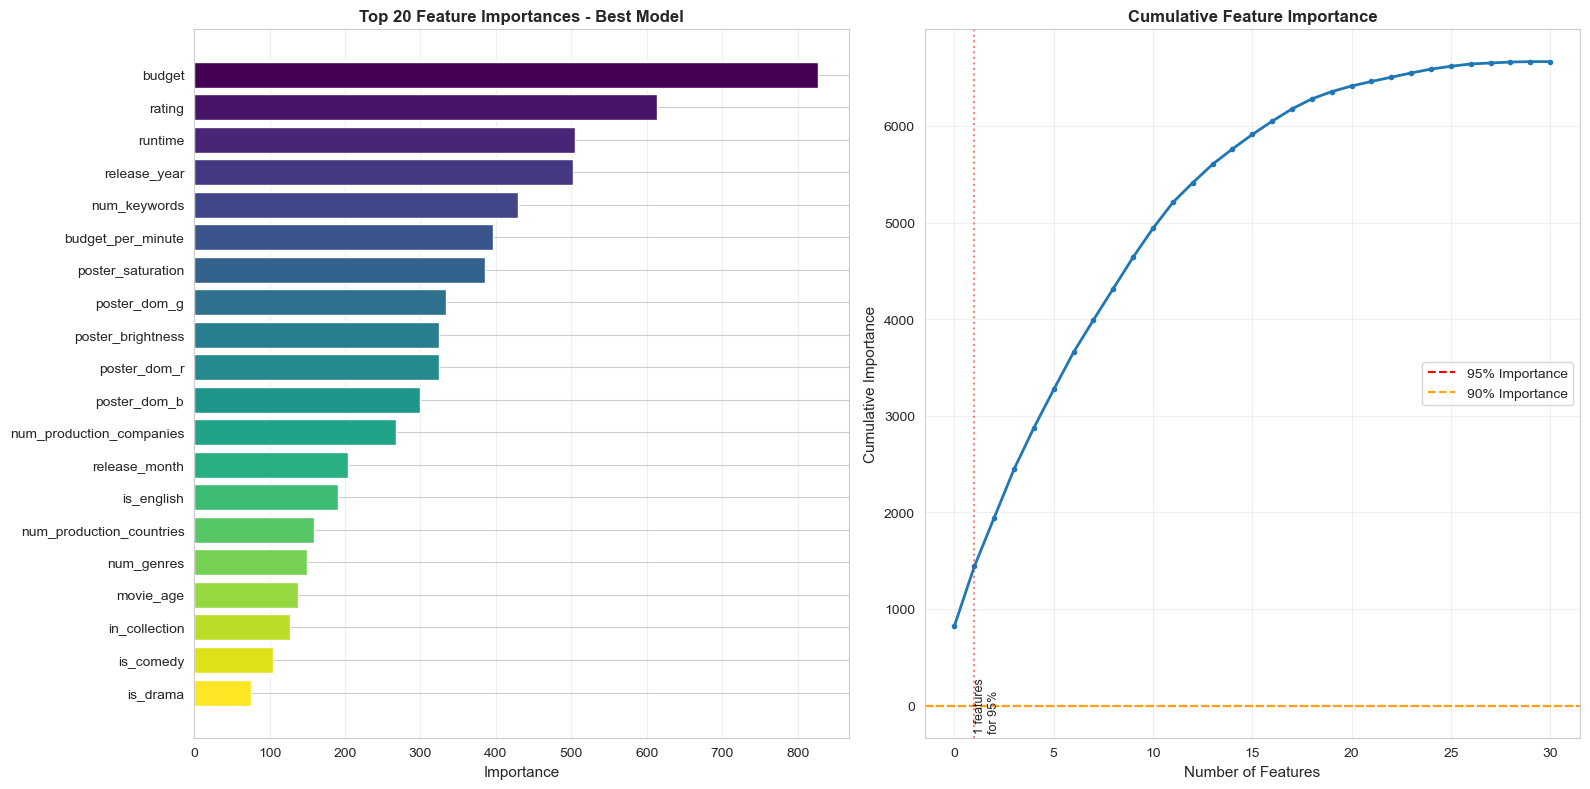


Number of features needed for 95% importance: 1/31


In [14]:
# Feature Importance Analysis
if hasattr(best_model, 'feature_importances_'):
    # Get feature importance
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\n" + "="*80)
    print("TOP 20 MOST IMPORTANT FEATURES")
    print("="*80)
    print(feature_importance.head(20).to_string(index=False))
    
    # Visualize top 20 features
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Horizontal bar chart
    ax1 = axes[0]
    top_features = feature_importance.head(20)
    colors = plt.cm.viridis(np.linspace(0, 1, 20))
    ax1.barh(range(20), top_features['importance'][::-1], color=colors[::-1])
    ax1.set_yticks(range(20))
    ax1.set_yticklabels(top_features['feature'][::-1])
    ax1.set_xlabel('Importance', fontsize=11)
    ax1.set_title(f'Top 20 Feature Importances - {best_model_name}', 
                  fontsize=12, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)
    
    # Cumulative importance
    ax2 = axes[1]
    cumulative_importance = np.cumsum(feature_importance['importance'].values)
    ax2.plot(range(len(cumulative_importance)), cumulative_importance, 
             linewidth=2, marker='o', markersize=3)
    ax2.axhline(y=0.95, color='red', linestyle='--', label='95% Importance')
    ax2.axhline(y=0.90, color='orange', linestyle='--', label='90% Importance')
    ax2.set_xlabel('Number of Features', fontsize=11)
    ax2.set_ylabel('Cumulative Importance', fontsize=11)
    ax2.set_title('Cumulative Feature Importance', fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    # Find features needed for 95% importance
    n_features_95 = np.argmax(cumulative_importance >= 0.95) + 1
    ax2.axvline(x=n_features_95, color='red', linestyle=':', alpha=0.5)
    ax2.text(n_features_95, 0.5, f'{n_features_95} features\nfor 95%', 
             rotation=90, verticalalignment='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nNumber of features needed for 95% importance: {n_features_95}/{len(feature_importance)}")
else:
    print(f"\n{best_model_name} does not provide feature importances.")